In [64]:
import networkx as nx
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import os
from io import StringIO
import re

from networkx.drawing.nx_pydot import read_dot
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import cluster, datasets
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans

%matplotlib inline
pd.set_option('display.max_columns', 500)


In [51]:
metadata_train = pd.read_csv("data/training_set_metadata.csv", sep = ";")

In [9]:
metadata_train.head()

,name,64-bit execution via heavens gate,64bits,PEB access,accept command line arguments,access the Windows event log,act as TCP client,allocate RW memory,allocate RWX memory,allocate memory,...,winzip,wise,worm,write and execute a file,write clipboard data,write file on Linux,write file on Windows,write pipe,xorcrypt,yoda
0,9fbf213113ba0a18dc2642f83b1201541428fd7951d6a8...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1b35c9dbf3cd9ac60015aaa6cd451c898defa6dac1ff43...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,bf8d307a136a936f7338c1f2eec773c4eb1c802cab77da...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1e51933903f0358c0b635f863368eb15a61cd3442bc5bf...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8a6503fe68d699f8a31531c157e9da931192cd7e3ec809...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


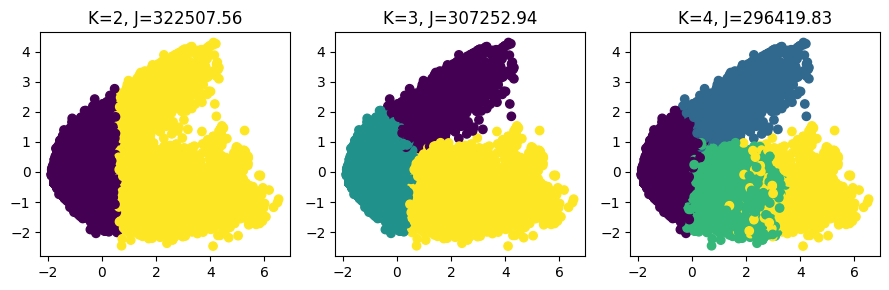

In [52]:
X = metadata_train.iloc[:, 1:] 

# Réduction de dimension avec PCA pour visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Appliquer K-Means avec différents nombres de clusters
km2 = cluster.KMeans(n_clusters=2, random_state=42, n_init=10).fit(X)
km3 = cluster.KMeans(n_clusters=3, random_state=42, n_init=10).fit(X)
km4 = cluster.KMeans(n_clusters=4, random_state=42, n_init=10).fit(X)

# Affichage des résultats
plt.figure(figsize=(9, 3))

plt.subplot(131)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km2.labels_, cmap='viridis')
plt.title("K=2, J=%.2f" % km2.inertia_)

plt.subplot(132)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km3.labels_, cmap='viridis')
plt.title("K=3, J=%.2f" % km3.inertia_)

plt.subplot(133)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km4.labels_, cmap='viridis')
plt.title("K=4, J=%.2f" % km4.inertia_)

plt.tight_layout()
plt.show()


In [ ]:

def train_kmeans_filling_model(metadata_train, n_clusters=3):
    """
    Entraîne un modèle KMeans sur les données binaires et retourne les clusters et leurs moyennes.
    :param metadata_train: DataFrame contenant les données binaires (0 et 1)
    :param n_clusters: Nombre de clusters à utiliser
    :return: Modèle KMeans entraîné et moyennes des clusters
    """
    X = metadata_train.iloc[:, 1:]  # Exclure l'ID si présent

    # Clustering KMeans
    kmeans = cluster.KMeans(n_clusters, random_state=42, n_init=10).fit(X)

    metadata_train["Cluster"] = kmeans.labels_
    # Calcul des moyennes des comportements par cluster
    cluster_means = metadata_train.iloc[:, 1:].groupby("Cluster").mean()

    return kmeans, cluster_means


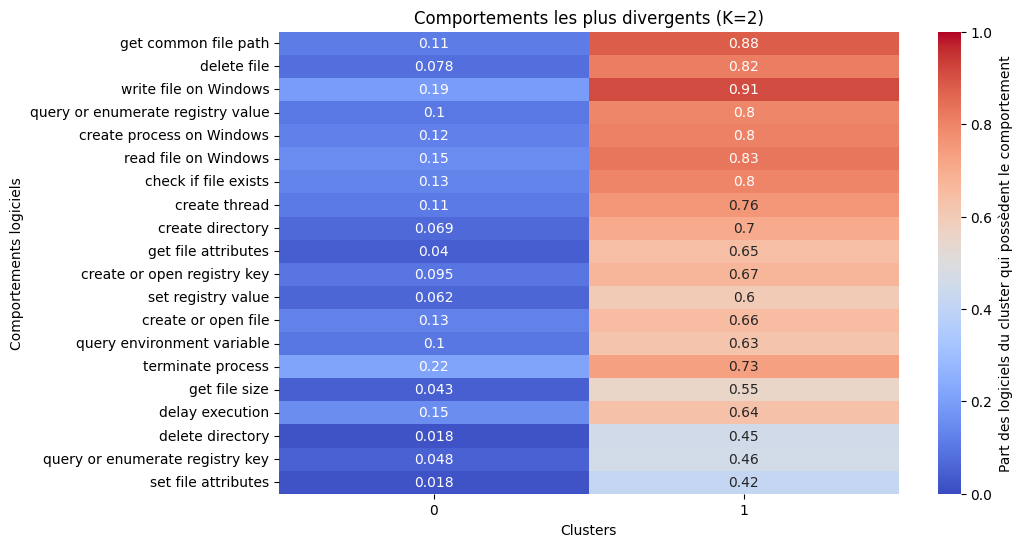

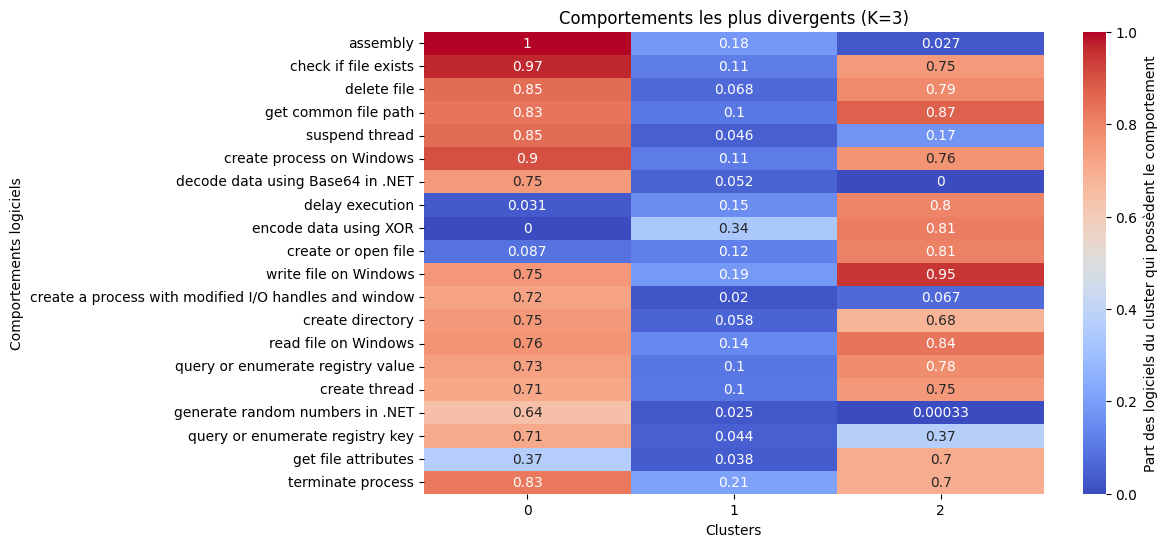

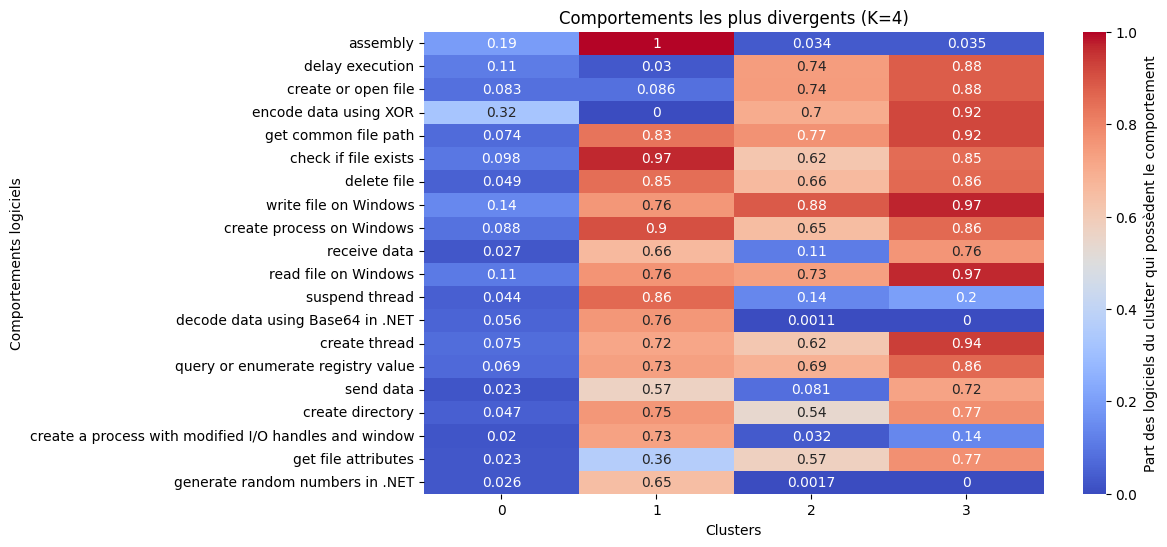

In [149]:
list_cluster = [2,3,4]


kmeans_models = {}
cluster_means_dict = {}

for nb_cluster in list_cluster:
    # Ajouter les labels des clusters aux données
    metadata_train = pd.read_csv("data/training_set_metadata.csv", sep = ";")

    kmeans, cluster_means =train_kmeans_filling_model(metadata_train, n_clusters=nb_cluster)

    kmeans_models[nb_cluster] = kmeans
    cluster_means_dict[nb_cluster] = cluster_means

    # Identifier les comportements les plus distinctifs (ceux qui varient le plus entre clusters)
    divergent_features = cluster_means.var().sort_values(ascending=False).head(20).index

    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(cluster_means[divergent_features].T, annot=True, cmap="coolwarm", vmin=0, vmax=1)
    cbar = ax.collections[0].colorbar
    cbar.set_label('Part des logiciels du cluster qui possèdent le comportement')

    plt.title(f"Comportements les plus divergents (K={nb_cluster})")
    plt.ylabel("Comportements logiciels")  # Inversé
    plt.xlabel("Clusters")  # Inversé
    plt.show()

J'aimerai construire un algorithme de remplissage des binaires pour de nouvelles lignes (nouveaux logiciels). Le problème que je suis capable de prédire seulement quelques comportement. J'aimerai en input donner les valeurs des comportements que je suir d'avoir bien prédit, et en output donner tous les comportements. L'agorithme doit regarder la classe la plus probable du logiciel par rapport aux profil des cluster et appliquer les valeurs majoritaires du cluster auquel le logiciel à le plus de chance d'appartenir.

Préparer les données :

Avoir les moyennes des comportements par cluster (comme on l'a fait précédemment).
Avoir les valeurs connues pour le logiciel à prédire.
Calculer la similarité entre les comportements observés du logiciel et chaque cluster (par exemple, en utilisant la distance Euclidienne ou d'autres mesures de distance).

Identifie le cluster le plus probable :

Une fois le cluster le plus probable trouvé, tu peux extraire les valeurs majoritaires pour ce cluster (par exemple, la valeur la plus fréquente pour chaque comportement).
Compléter les comportements manquants avec ces valeurs majoritaires du cluster identifié.

In [155]:

def fill_missing_behaviors(known_behaviors, kmeans, cluster_means):
    """
    
    Complète les comportements inconnus en fonction du cluster le plus probable.
    :param known_behaviors: Liste avec des valeurs connues (0, 1) et des -1 pour les inconnues.
    :param kmeans: Modèle KMeans entraîné.
    :param cluster_means: Moyennes des comportements par cluster.
    :return: Comportements complétés, Cluster prédit
    """
    known_behaviors = np.array(known_behaviors).reshape(1, -1)
    # Filtrer les indices des valeurs connues
    mask_known = (known_behaviors != -1).reshape(-1)

    # Calculer la distance aux clusters en ne prenant en compte que les valeurs connues
    distances = []
    for i, cluster_center in enumerate(kmeans.cluster_centers_):
        cluster_center_filtered = cluster_center[mask_known]
        known_filtered = known_behaviors[0][mask_known]
        distance = np.linalg.norm(cluster_center_filtered - known_filtered)  # Distance euclidienne
        distances.append(distance)

    # Trouver le cluster le plus proche
    best_cluster = np.argmin(distances)

    # Remplir les valeurs inconnues avec les moyennes du cluster trouvé
    filled_behaviors = known_behaviors.copy()
    for i in range(len(filled_behaviors[0])):
        if filled_behaviors[0][i] == -1:  # Si la valeur est inconnue
            filled_behaviors[0][i] = 1 if cluster_means.iloc[best_cluster, i] > 0.5 else 0

    return filled_behaviors[0], best_cluster



In [154]:
new_software_behaviors = [-1] * 453  # 453 comportements inconnus au départ
new_software_behaviors[2] = 1  

selected_k = 4
kmeans = kmeans_models[selected_k]
cluster_means = cluster_means_dict[selected_k]
predicted_behaviors, predicted_cluster = fill_missing_behaviors(new_software_behaviors, kmeans, cluster_means)

# Affichage des résultats
print(f"Comportements connus (extrait) : {new_software_behaviors[:10]}...")
print(f"Comportements complétés (extrait) : {predicted_behaviors[:10]}...")
print(f"Le logiciel est le plus proche du cluster : {predicted_cluster}")

Comportements connus (extrait) : [-1, -1, 1, -1, -1, -1, -1, -1, -1, -1]...
Comportements complétés (extrait) : [0 0 1 0 0 0 0 0 0 0]...
Le logiciel est le plus proche du cluster : 3


In [152]:
for i, col in enumerate(metadata_train.iloc[:,1:].columns):
    print(f"Index {i}: {col}")


Index 0: 64-bit execution via heavens gate
Index 1: 64bits
Index 2: PEB access
Index 3: accept command line arguments
Index 4: access the Windows event log
Index 5: act as TCP client
Index 6: allocate RW memory
Index 7: allocate RWX memory
Index 8: allocate memory
Index 9: allocate or change RW memory
Index 10: allocate or change RWX memory
Index 11: allocate thread local storage
Index 12: android
Index 13: anorganix
Index 14: apatch
Index 15: apk
Index 16: arm
Index 17: armadillo
Index 18: aspack
Index 19: asprotect
Index 20: assembly
Index 21: attach user process memory
Index 22: attachment
Index 23: authenticate HMAC
Index 24: block operations on executable memory pages using Arbitrary Code Guard
Index 25: bobsoft
Index 26: bypass Windows File Protection
Index 27: calculate modulo 256 via x86 assembly
Index 28: calls-wmi
Index 29: capture screenshot
Index 30: capture screenshot in Go
Index 31: cexe
Index 32: change file permission on Linux
Index 33: change memory protection
Index 34